In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import popoff
from Session import SessionLite, build_flu_array_single
from mpl_toolkits.mplot3d import Axes3D
from linear_model import PoolAcrossSessions, LinearModel, pca_session, LabelEncoder, largest_PC_trace, largest_PC_loading, do_pca
import loadpaths
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys, os, pickle, copy
from sklearn.decomposition import PCA
import warnings
import pandas as pd
import math, cmath
from tqdm import tqdm
import pop_off_functions as pof
import pop_off_plotting as pop
from IPython.core.debugger import Pdb
ipdb = Pdb()
import ptitprince as pt
import copy
from datetime import datetime

## Load data in form of Jimmy's PAS object
warnings.warn('Targets in data, fix self.ever_targetted')
remove_targets = False
pas = PoolAcrossSessions(save_PCA=False, subsample_sessions=False,
                         remove_targets=remove_targets, remove_toosoon = True)
lm = pas.linear_models[0]
print(pas.sessions)

/home/tplas/repos/popping-off/popoff/popoff/loadpaths.py
/home/tplas/repos/Vape
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
{0: instance Mouse J064, run 10 of Session class, 1: instance Mouse J064, run 11 of Session class, 2: instance Mouse J064, run 14 of Session class, 3: instance Mouse RL070, run 28 of Session class, 4: instance Mouse RL070, run 29 of Session class, 5: instance Mouse RL117, run 29 of Session class, 6: instance Mouse RL117, run 30 of Session class, 7: instance Mouse RL123, run 22 of Session class, 8: instance Mouse RL116, run 32 of Session class, 9: instance Mouse RL116, run 33 of Session class}


In [3]:
## Create sessions object from PAS:

try:  # ensure sessions doesn't exist yet 
    sessions
    assert type(sessions) is dict
except NameError:
    pass

sessions = {}
int_keys_pas_sessions = pas.sessions.keys()
print(int_keys_pas_sessions)
i_s = 0
for ses in pas.sessions.values():  # load into sessions dict (in case pas skips an int as key)
    ses.signature = f'{ses.mouse}_R{ses.run_number}'
    sessions[i_s] = ses
    i_s += 1
#     if ses.signature != 'RL117_R29':  # one that used not to have spont data
#         sessions[i_s] = ses
#         i_s += 1
#     else:
#         f'{ses.signature} has been excluded !!! (because no spont data available)'
print(sessions)
assert len(sessions) == 10
pof.label_urh_arm(sessions=sessions)  # label arm and urh

# for kk, ss in sessions.items():
    
    
print('------------------------------------')
print(f'{len(sessions)} sessions are loaded')
tp_dict = pof.create_tp_dict(sessions=sessions)


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
{0: instance Mouse J064, run 10 of Session class, 1: instance Mouse J064, run 11 of Session class, 2: instance Mouse J064, run 14 of Session class, 3: instance Mouse RL070, run 28 of Session class, 4: instance Mouse RL070, run 29 of Session class, 5: instance Mouse RL117, run 29 of Session class, 6: instance Mouse RL117, run 30 of Session class, 7: instance Mouse RL123, run 22 of Session class, 8: instance Mouse RL116, run 32 of Session class, 9: instance Mouse RL116, run 33 of Session class}
URH and ARM trials have been labelled
------------------------------------
10 sessions are loaded


In [4]:
## Add VCR measurements to session objects
pof.add_vcr_to_lm(lm_list=pas.linear_models)

0it [00:00, ?it/s]/home/tplas/anaconda3/envs/pope/lib/python3.7/site-packages/sklearn/utils/extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/tplas/anaconda3/envs/pope/lib/python3.7/site-packages/sklearn/utils/extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/home/tplas/anaconda3/envs/pope/lib/python3.7/site-packages/sklearn/utils/extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/tplas/anaconda3/envs/pope/lib/python3.7/site-packages/sklearn/utils/extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
1it [00:24, 24.64s/it]/home/tplas/anaconda3/envs/pope/lib/python3.7/site-packages/sklearn/utils/extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated

In [6]:
tp_dict['decoders'] = tp_dict['mutual']
tp_dict['decoders'] = tp_dict['decoders'][np.logical_and(tp_dict['decoders'] >- 2, 
                                                         tp_dict['decoders'] <= 4)]
tp_dict['decoders'] = tp_dict['decoders']#[::4]

pre_stim_art_time = -0.07
post_stim_art_time = 0.35
time_array_plot = copy.deepcopy(tp_dict['decoders'])
time_array_full = copy.deepcopy(tp_dict['decoders'])
time_array_plot[np.logical_and(time_array_plot >= pre_stim_art_time, 
                               time_array_plot < post_stim_art_time)] = np.nan
time_array_full -= pre_stim_art_time
time_array_plot -= pre_stim_art_time


dict_tt_train = {'hit/cr': ['hit', 'cr'],
                 'hit/miss': ['hit', 'miss'],
                 'miss/cr': ['miss', 'cr']}
#                  'spont/cr': ['spont', 'cr'],
#                  'hit/cr 10 trials': ['hit', 'cr']}  # to run 10 trials; set hard_set_10_trials to True

## Uncomment these lines to run, (this resets the decoder results)
# lick_acc, lick_acc_split, lick_pred_split, ps_acc, ps_acc_split = {}, {}, {}, {}, {}
# ps_pred_split, lick_half, angle_dec, decoder_weights = {}, {}, {}, {}

lick_pred_split_tt, lick_pred_split_tt_nstim, lick_pred_split_tt_covar = {}, {} ,{}
ps_pred_split_tt, ps_pred_split_tt_nstim, ps_pred_split_tt_covar = {}, {}, {}

## Train decoders (takes 15 mins per decoder type)

In [7]:
## Compute results decoders (note: CV of regularisation is down below in the notebook)

for key, list_tt_train in dict_tt_train.items():
#     if key == 'hit/cr 10 trials':
    print(f'Now training {key} decoder')

#     (lick_acc[key], lick_acc_split[key], lick_pred_split[key], ps_acc[key], 
#      ps_acc_split[key], ps_pred_split[key], lick_half[key], angle_dec[key], 
#      decoder_weights[key]) = pof.compute_accuracy_time_array_average_per_mouse(sessions=sessions, 
#                                                   time_array=tp_dict['decoders'],
#                                                   projected_data=False, 
#                                                   reg_type='l2', regularizer=1, 
#                                                   average_fun=pof.class_av_mean_accuracy,
#                                                   split_fourway=True,
#                                                   list_tt_training=list_tt_train,
#                                                   concatenate_sessions_per_mouse=False,
#                                                   hard_set_10_trials=(True if key == 'hit/cr 10 trials' else False))
    
    
    (lick_pred_split_tt[key], lick_pred_split_tt_nstim[key], 
     lick_pred_split_tt_covar[key], ps_pred_split_tt[key], 
     ps_pred_split_tt_nstim[key], 
     ps_pred_split_tt_covar[key]) = pof.compute_prediction_time_array_average_per_mouse_split(sessions=sessions, 
                                                  time_array=tp_dict['decoders'],
                                                  projected_data=False, 
                                                  reg_type='l2', regularizer=1, 
                                                  average_fun=pof.class_av_mean_accuracy,
                                                  list_tt_training=list_tt_train,
                                                  concatenate_sessions_per_mouse=False,
                                                  hard_set_10_trials=(True if key == 'hit/cr 10 trials' else False),
                                                  list_save_covs=['variance_cell_rates_s1'])

0it [00:00, ?it/s]

Now training hit/cr decoder


180it [20:56,  6.98s/it]
0it [00:00, ?it/s]

Now training hit/miss decoder


180it [16:46,  5.59s/it]
0it [00:00, ?it/s]

Now training miss/cr decoder


180it [16:54,  5.64s/it]


In [35]:
# tmp = pof.compute_prediction_time_array_average_per_mouse_split(sessions=sessions, 
#                                                   time_array=tp_dict['decoders'],
#                                                   projected_data=False, 
#                                                   reg_type='l2', regularizer=1, 
#                                                   average_fun=pof.class_av_mean_accuracy,
#                                                   list_tt_training=list_tt_train,
#                                                   concatenate_sessions_per_mouse=False,
#                                                   hard_set_10_trials=(True if key == 'hit/cr 10 trials' else False),
#                                                   list_save_covs=['variance_cell_rates_s1'])

In [34]:
# print(tmp[1].keys())
# df_tmp = tmp[1]['RL070_R28']

# for tt in ['hit', 'miss']:
#     plt.hist(df_tmp['variance_cell_rates_s1_test'][df_tmp['outcome_test'] == tt], 
#              bins=np.linspace(-2, 2, 20), histtype='step', label=tt, density=True)
# plt.legend()

In [52]:
ps_pred_split_tt_nstim['hit/cr']['hit_n1']['J064_R10_s1'].shape

(180, 2)

skipping RL116_R32_s1
skipping J064_R10_s1
skipping RL123_R22_s1
skipping J064_R10_s2
skipping RL123_R22_s2


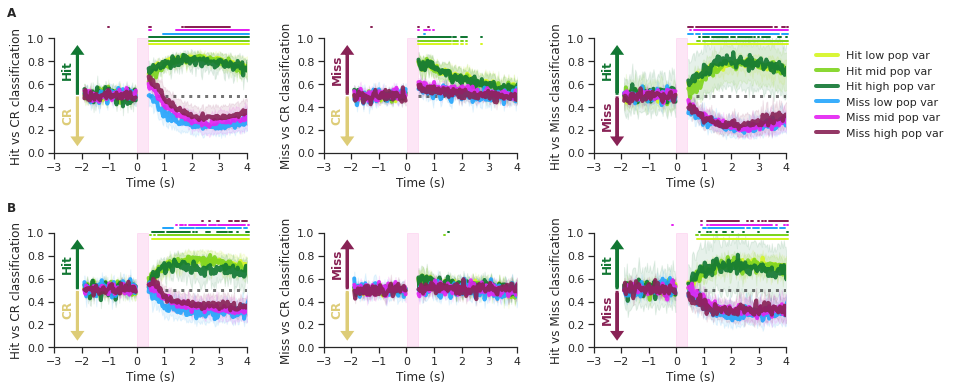

In [41]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=(16, 5.5))
gs_dyn_dec = fig.add_gridspec(ncols=4, nrows=2, bottom=0.12, top=0.9, right=0.97, left=0.1,
                              wspace=0.4, hspace=0.7)
hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}
hitmiss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 2]), 's2': fig.add_subplot(gs_dyn_dec[1, 2])}

pop.plot_dynamic_decoding_two_regions_wrapper_split(ps_pred_split=ps_pred_split_tt_covar, 
                                                    lick_pred_split=lick_pred_split_tt_covar,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                                    plot_legend=False,
                                              time_array=time_array_plot)

pop.plot_dynamic_decoding_two_regions_wrapper_split(ps_pred_split=ps_pred_split_tt_covar, 
                                                    lick_pred_split=lick_pred_split_tt_covar,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                                    plot_legend=False,
                                              time_array=time_array_plot)

pop.plot_dynamic_decoding_two_regions_wrapper_split(ps_pred_split=ps_pred_split_tt_covar, 
                                                    lick_pred_split=lick_pred_split_tt_covar,
                                              decoder_key='hit/miss', ax_acc_ps=hitmiss_ax_dict, 
                                                    plot_legend=True,
                                              time_array=time_array_plot)


for reg in ['s1' ,'s2']:
#     miss_ax_dict[reg].set_title(f'Dynamic stimulus encoding in {reg.upper()}', 
#                                x=1.25, y=1.14, fontdict={'weight': 'bold'})    
    hit_ax_dict[reg].set_title('')
    hitmiss_ax_dict[reg].set_title('')
    miss_ax_dict[reg].set_title('')
    hit_ax_dict[reg].text(s=('A' if reg == 's1' else 'B'), x=-4.7, y=1.19,
                          fontdict={'weight': 'bold'})
#     miss_ax_dict[reg].text(s=('C' if reg == 's1' else 'D'), x=-4.5, y=1.19,
#                           fontdict={'weight': 'bold'})
#     hitmiss_ax_dict[reg].text(s=('E' if reg == 's1' else 'F'), x=-4.5, y=1.19,
#                           fontdict={'weight': 'bold'})
    
#     pop.naked(miss_ax_dict[reg])
    
if save_fig:        
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/fig3_supp_split_popvar.pdf',
                bbox_to_inches='tight')

skipping RL117_R30_s1
skipping J064_R10_s1
skipping RL117_R30_s2
skipping J064_R10_s2
skipping RL117_R30_s1
skipping J064_R10_s1
skipping RL117_R30_s2
skipping J064_R10_s2
skipping J064_R10_s1
skipping RL117_R30_s1
skipping RL123_R22_s1
skipping J064_R10_s1
skipping RL117_R30_s1
skipping J064_R10_s2
skipping RL117_R30_s2
skipping RL123_R22_s2
skipping J064_R10_s2
skipping RL117_R30_s2


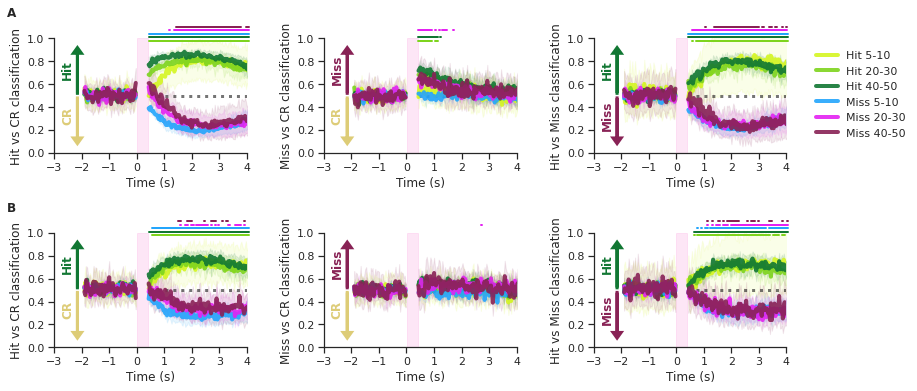

In [42]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=(16, 5.5))
gs_dyn_dec = fig.add_gridspec(ncols=4, nrows=2, bottom=0.12, top=0.9, right=0.97, left=0.1,
                              wspace=0.4, hspace=0.7)
hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}
hitmiss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 2]), 's2': fig.add_subplot(gs_dyn_dec[1, 2])}

pop.plot_dynamic_decoding_two_regions_wrapper_split(ps_pred_split=ps_pred_split_tt_nstim, 
                                                    lick_pred_split=lick_pred_split_tt_nstim,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                                    plot_legend=False, name_cov=None,
                                                    plot_tt=['hit_n1', 'hit_n2', 'hit_n3', 
                                                       'miss_n1', 'miss_n2', 'miss_n3'],
                                              time_array=time_array_plot)

pop.plot_dynamic_decoding_two_regions_wrapper_split(ps_pred_split=ps_pred_split_tt_nstim, 
                                                    lick_pred_split=lick_pred_split_tt_nstim,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                                    plot_legend=False,name_cov=None,
                                                    plot_tt=['hit_n1', 'hit_n2', 'hit_n3', 
                                                       'miss_n1', 'miss_n2', 'miss_n3'],
                                              time_array=time_array_plot)

pop.plot_dynamic_decoding_two_regions_wrapper_split(ps_pred_split=ps_pred_split_tt_nstim, 
                                                    lick_pred_split=lick_pred_split_tt_nstim,
                                              decoder_key='hit/miss', ax_acc_ps=hitmiss_ax_dict, 
                                                    plot_legend=True,name_cov=None,
                                                    plot_tt=['hit_n1', 'hit_n2', 'hit_n3', 
                                                       'miss_n1', 'miss_n2', 'miss_n3'],
                                              time_array=time_array_plot)


for reg in ['s1' ,'s2']:
#     miss_ax_dict[reg].set_title(f'Dynamic stimulus encoding in {reg.upper()}', 
#                                x=1.25, y=1.14, fontdict={'weight': 'bold'})    
    hit_ax_dict[reg].set_title('')
    hitmiss_ax_dict[reg].set_title('')
    miss_ax_dict[reg].set_title('')
    hit_ax_dict[reg].text(s=('A' if reg == 's1' else 'B'), x=-4.7, y=1.19,
                          fontdict={'weight': 'bold'})
#     miss_ax_dict[reg].text(s=('C' if reg == 's1' else 'D'), x=-4.5, y=1.19,
#                           fontdict={'weight': 'bold'})
#     hitmiss_ax_dict[reg].text(s=('E' if reg == 's1' else 'F'), x=-4.5, y=1.19,
#                           fontdict={'weight': 'bold'})
    
#     pop.naked(miss_ax_dict[reg])
    
if save_fig:        
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/fig3_supp_split_nstim.pdf',
                bbox_to_inches='tight')

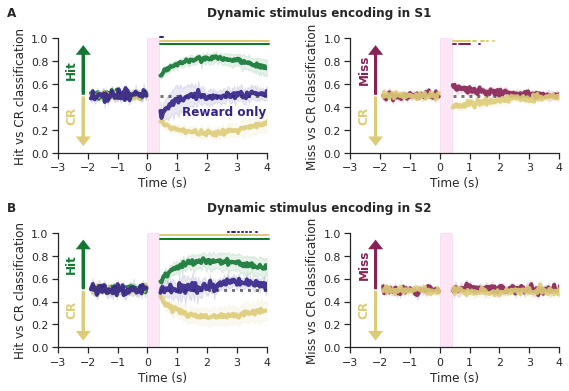

In [40]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=(8, 5.5))
gs_dyn_dec = fig.add_gridspec(ncols=2, nrows=2, bottom=0.12, top=0.9, right=0.97, left=0.1,
                              wspace=0.4, hspace=0.7)
hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split_tt, lick_pred_split=lick_pred_split_tt,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                              plot_tt=['hit', 'cr', 'spont'], plot_legend=False,
                                              time_array=time_array_plot, indicate_spont=True)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split_tt, lick_pred_split=lick_pred_split_tt,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                              plot_tt=['miss', 'cr'], plot_legend=False,
                                              time_array=time_array_plot)

for reg in ['s1' ,'s2']:
    hit_ax_dict[reg].set_title(f'Dynamic stimulus encoding in {reg.upper()}', 
                               x=1.25, y=1.14, fontdict={'weight': 'bold'})    
    miss_ax_dict[reg].set_title('')
    hit_ax_dict[reg].text(s=('A' if reg == 's1' else 'B'), x=-4.7, y=1.19,
                          fontdict={'weight': 'bold'})
    
if save_fig:        
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/fig3_main.pdf',
                bbox_to_inches='tight')

# Additional stat tests:

In [277]:
## Miss vs CR in S1 is significant until:

tmp = pof.stat_test_dyn_dec(pred_dict=ps_pred_split, decoder_name='miss/cr', tt='cr', region='s1',
                      time_array=time_array_plot, frames_bin=2, th=0.05)

time_array_plot[tmp[1].astype('bool')]

array([0.43666667, 0.47      , 0.50333333, 0.53666667, 0.57      ,
       0.60333333, 0.63666667, 0.67      , 0.70333333, 0.73666667,
       0.77      , 0.80333333, 0.83666667, 0.87      , 0.90333333,
       0.93666667, 0.97      , 1.00333333, 1.03666667, 1.07      ,
       1.17      , 1.20333333, 1.23666667, 1.27      , 1.30333333,
       1.33666667, 1.37      , 1.40333333, 1.63666667, 1.67      ,
       1.70333333, 1.73666667, 1.83666667, 1.87      , 2.90333333,
       2.93666667])

array([0.43666667, 0.47      , 0.50333333, 0.53666667, 0.57      ,
       0.60333333, 0.63666667, 0.67      , 0.70333333, 0.73666667,
       0.77      , 0.80333333, 0.83666667, 0.87      , 0.90333333,
       0.93666667, 0.97      , 1.00333333, 1.03666667, 1.07      ,
       1.17      , 1.20333333, 1.30333333, 1.33666667, 1.37      ,
       1.40333333, 1.83666667, 1.87      , 2.57      , 2.60333333])

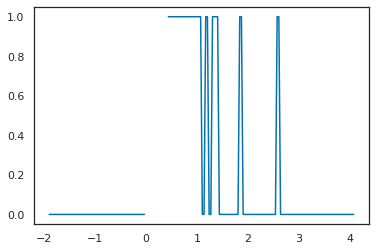

In [279]:
## Miss vs CR in S1 is significant until:

tmp = pof.stat_test_dyn_dec_two_arrays(pred_dict_1=ps_pred_split, decoder_name_1='miss/cr', tt_1='miss', region_1='s1',
                                 pred_dict_2=ps_pred_split, decoder_name_2='miss/cr', tt_2='cr', region_2='s1',
                                 time_array=time_array_plot, frames_bin=2, th=0.05, 
                                 alternative='two-sided')

plt.plot(time_array_plot, tmp[2])

time_array_plot[tmp[2].astype('bool')]


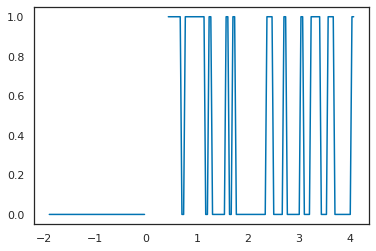

In [273]:
## Hit vs CR performance is greater in S1 than in S2:

tmp = pof.stat_test_dyn_dec_two_arrays(pred_dict_1=ps_pred_split, decoder_name_1='hit/cr', tt_1='cr', region_1='s1',
                                 pred_dict_2=ps_pred_split, decoder_name_2='hit/cr', tt_2='cr', region_2='s2',
                                 time_array=time_array_plot, frames_bin=2, th=0.05, 
                                 alternative='two-sided')

plt.plot(time_array_plot, tmp[2])

## Use (Hit - CR) performance. 

In [283]:
## Spont vs CR in S1 is not significant until:

tmp = pof.stat_test_dyn_dec(pred_dict=ps_pred_split, decoder_name='hit/cr', tt='spont', region='s2',
                      time_array=time_array_plot, frames_bin=2, th=0.05)

time_array_plot[tmp[1].astype('bool')]

array([2.77      , 2.80333333, 2.90333333, 2.93666667, 3.10333333,
       3.13666667, 3.30333333, 3.33666667, 3.43666667, 3.47      ,
       3.63666667, 3.67      , 3.83666667, 3.87      ])

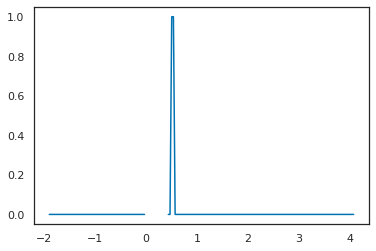

In [284]:
## Hit and Spont are identical on Spont/CR decoder

## Hit vs CR performance is greater in S1 than in S2:
reg = 's2'
tmp = pof.stat_test_dyn_dec_two_arrays(pred_dict_1=lick_pred_split, decoder_name_1='spont/cr', tt_1='hit', region_1=reg,
                                 pred_dict_2=lick_pred_split, decoder_name_2='spont/cr', tt_2='spont', region_2=reg,
                                 time_array=time_array_plot, frames_bin=2, th=0.05, 
                                 alternative='two-sided')

plt.plot(time_array_plot, tmp[2])

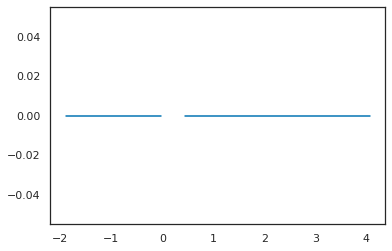

In [362]:
## Hit and Spont are identical on Spont/CR decoder

## Hit vs CR performance is greater in S1 than in S2:
reg = 's2'
tmp = pof.stat_test_dyn_dec_two_arrays(pred_dict_1=ps_pred_split, decoder_name_1='hit/cr 10 trials', tt_1='hit', region_1=reg,
                                 pred_dict_2=lick_pred_split, decoder_name_2='spont/cr', tt_2='spont', region_2=reg,
                                 time_array=time_array_plot, frames_bin=2, th=0.05, 
                                 alternative='two-sided')

plt.plot(time_array_plot, tmp[2])

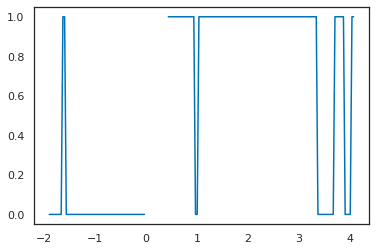

In [358]:
reg = 's1'
tmp = pof.stat_test_dyn_dec_two_arrays(pred_dict_1=ps_pred_split, decoder_name_1='hit/cr 10 trials', tt_1='hit', region_1=reg,
                                 pred_dict_2=lick_pred_split, decoder_name_2='hit/cr', tt_2='spont', region_2=reg,
                                 time_array=time_array_plot, frames_bin=2, th=0.05, 
                                 alternative='two-sided')

plt.plot(time_array_plot, tmp[2])

In [359]:
time_array_plot[70:148]

array([0.43666667, 0.47      , 0.50333333, 0.53666667, 0.57      ,
       0.60333333, 0.63666667, 0.67      , 0.70333333, 0.73666667,
       0.77      , 0.80333333, 0.83666667, 0.87      , 0.90333333,
       0.93666667, 0.97      , 1.00333333, 1.03666667, 1.07      ,
       1.10333333, 1.13666667, 1.17      , 1.20333333, 1.23666667,
       1.27      , 1.30333333, 1.33666667, 1.37      , 1.40333333,
       1.43666667, 1.47      , 1.50333333, 1.53666667, 1.57      ,
       1.60333333, 1.63666667, 1.67      , 1.70333333, 1.73666667,
       1.77      , 1.80333333, 1.83666667, 1.87      , 1.90333333,
       1.93666667, 1.97      , 2.00333333, 2.03666667, 2.07      ,
       2.10333333, 2.13666667, 2.17      , 2.20333333, 2.23666667,
       2.27      , 2.30333333, 2.33666667, 2.37      , 2.40333333,
       2.43666667, 2.47      , 2.50333333, 2.53666667, 2.57      ,
       2.60333333, 2.63666667, 2.67      , 2.70333333, 2.73666667,
       2.77      , 2.80333333, 2.83666667, 2.87      , 2.90333

In [360]:
np.sum(tmp[2][70:]), len(tmp[2][70:])

(94.0, 110)

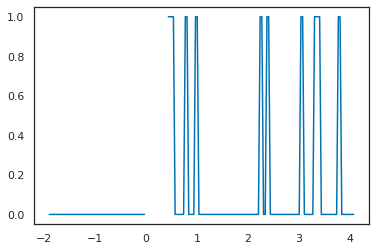

In [317]:
## hit cr difference greater in s1 than s2

tmp = pof.stat_test_dyn_dec_two_difference_arrays(pred_dict_1=ps_pred_split, decoder_name_1='hit/cr', tt_1_pos='hit', 
                                                  tt_1_neg='cr', region_1='s1',
                                 pred_dict_2=ps_pred_split, decoder_name_2='hit/cr', tt_2_pos='hit', tt_2_neg='cr',
                                                  region_2='s2',
                                 time_array=time_array_plot, frames_bin=2, th=0.05, 
                                 alternative='two-sided')

plt.plot(time_array_plot, tmp[1])

In [318]:
np.sum(tmp[1])

20.0

# Supp 1 (all trial types)

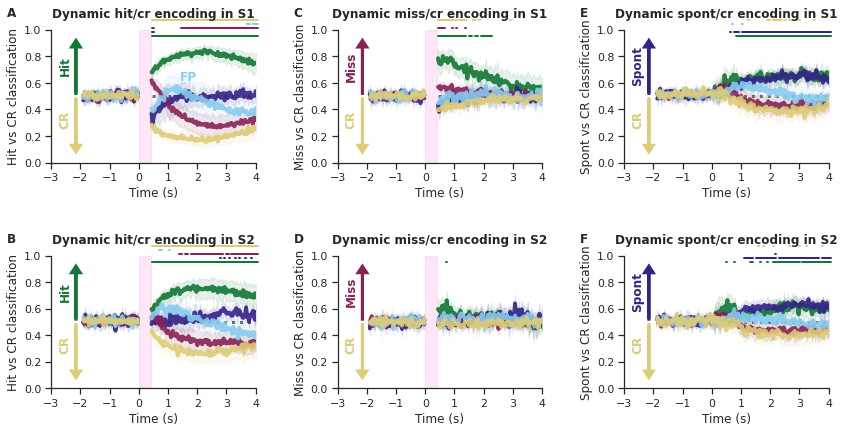

In [152]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=(12, 6))
gs_dyn_dec = fig.add_gridspec(ncols=3, nrows=2, bottom=0.1, top=0.93, right=0.97, left=0.07,
                              wspace=0.4, hspace=0.7)

hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}
spont_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 2]), 's2': fig.add_subplot(gs_dyn_dec[1, 2])}

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False,
                                              indicate_fp=True)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False)


pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='spont/cr', ax_acc_ps=spont_ax_dict, 
                                              time_array=time_array_full, plot_legend=False, plot_artefact=False)

for reg in ['s1', 's2']:
    hit_ax_dict[reg].text(s=('A' if reg == 's1' else 'B'), x=-4.5, y=1.1,
                          fontdict={'weight': 'bold'})
    miss_ax_dict[reg].text(s=('C' if reg == 's1' else 'D'), x=-4.5, y=1.1,
                          fontdict={'weight': 'bold'})
    spont_ax_dict[reg].text(s=('E' if reg == 's1' else 'F'), x=-4.5, y=1.1,
                          fontdict={'weight': 'bold'})
    
if save_fig:
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/fig3_supp1.pdf',
                bbox_to_inches='tight')
    

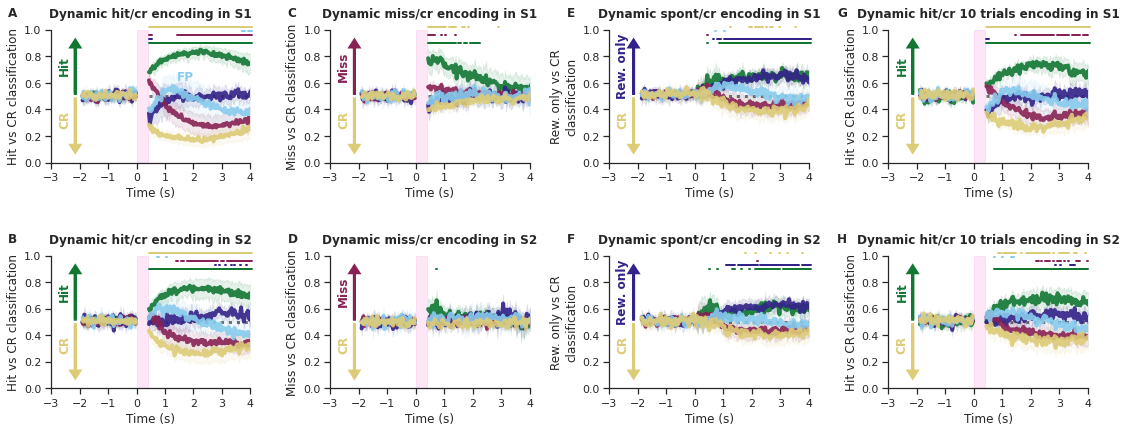

In [329]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=(16, 6))
gs_dyn_dec = fig.add_gridspec(ncols=4, nrows=2, bottom=0.1, top=0.93, right=0.97, left=0.07,
                              wspace=0.4, hspace=0.7)

hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}
spont_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 2]), 's2': fig.add_subplot(gs_dyn_dec[1, 2])}
hit10_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 3]), 's2': fig.add_subplot(gs_dyn_dec[1, 3])}

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False,
                                              indicate_fp=True, bottom_sign_bar=0.9)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False, bottom_sign_bar=0.9)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='spont/cr', ax_acc_ps=spont_ax_dict, 
                                              time_array=time_array_full, plot_legend=False, 
                                              plot_artefact=False, bottom_sign_bar=0.9)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='hit/cr 10 trials', ax_acc_ps=hit10_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False, bottom_sign_bar=0.9)

for reg in ['s1', 's2']:
    hit_ax_dict[reg].text(s=('A' if reg == 's1' else 'B'), x=-4.5, y=1.1,
                          fontdict={'weight': 'bold'})
    miss_ax_dict[reg].text(s=('C' if reg == 's1' else 'D'), x=-4.5, y=1.1,
                          fontdict={'weight': 'bold'})
    spont_ax_dict[reg].text(s=('E' if reg == 's1' else 'F'), x=-4.5, y=1.1,
                          fontdict={'weight': 'bold'})
    hit10_ax_dict[reg].text(s=('G' if reg == 's1' else 'H'), x=-4.8, y=1.1,
                          fontdict={'weight': 'bold'})
    
if save_fig:
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/fig3_supp1_v2.pdf',
                bbox_to_inches='tight')
    

# Supp 2 (indiv animals)

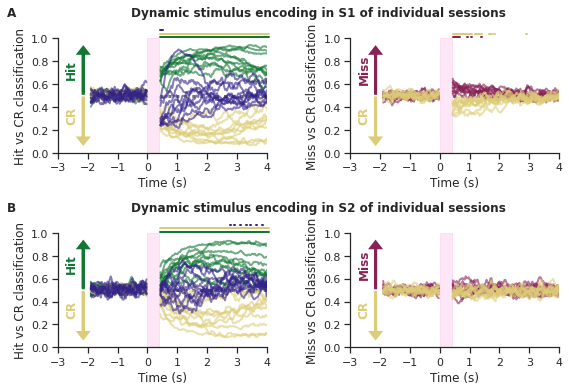

In [337]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=(8, 5.5))
gs_dyn_dec = fig.add_gridspec(ncols=2, nrows=2, bottom=0.12, top=0.9, right=0.97, left=0.1,
                              wspace=0.4, hspace=0.7)
hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                              plot_indiv=True, smooth_traces=True,
                                              plot_tt=['hit', 'cr', 'spont'], plot_legend=False,
                                              time_array=time_array_plot, indicate_spont=False,
                                              plot_mean=False,
                                              bottom_sign_bar=1.01, plot_ci=False)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                              plot_indiv=True, smooth_traces=True,
                                              plot_tt=['miss', 'cr'], plot_legend=False,
                                              plot_ci=False, plot_mean=False,
                                              time_array=time_array_plot, bottom_sign_bar=1.01)

for reg in ['s1' ,'s2']:
    hit_ax_dict[reg].set_title(f'Dynamic stimulus encoding in {reg.upper()} of individual sessions', 
                               x=1.25, y=1.14, fontdict={'weight': 'bold'})    
    miss_ax_dict[reg].set_title('')
    hit_ax_dict[reg].text(s=('A' if reg == 's1' else 'B'), x=-4.7, y=1.19,
                          fontdict={'weight': 'bold'})
    
if save_fig:        
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/fig3_supp_indiv_sessions.pdf',
                bbox_to_inches='tight')

# Optimize regularisation strength

In [82]:
tp_dict['decoders'] = tp_dict['mutual']
tp_dict['decoders'] = tp_dict['decoders'][np.logical_and(tp_dict['decoders'] >- 2, 
                                                         tp_dict['decoders'] <= 4)]
tp_dict['decoders'] = tp_dict['decoders']#[::60]

pre_stim_art_time = -0.07
post_stim_art_time = 0.35
time_array_plot = copy.deepcopy(tp_dict['decoders'])
time_array_full = copy.deepcopy(tp_dict['decoders'])
time_array_plot[np.logical_and(time_array_plot >= pre_stim_art_time, 
                               time_array_plot < post_stim_art_time)] = np.nan
time_array_full -= pre_stim_art_time
time_array_plot -= pre_stim_art_time


dict_tt_train = {'hit/cr': ['hit', 'cr'],
                 'hit/miss': ['hit', 'miss'],
                 'miss/cr': ['miss', 'cr'],
                 'spont/cr': ['spont', 'cr'],
                 'hit/cr 10 trials': ['hit', 'cr']}  # to run 10 trials; set hard_set_10_trials to True

## Uncomment these lines to run, (this resets the decoder results)
# lick_acc, lick_acc_split, lick_pred_split, ps_acc, ps_acc_split = {}, {}, {}, {}, {}
# ps_pred_split, lick_half, angle_dec, decoder_weights = {}, {}, {}, {}

all_lick_pred_split_tt, all_lick_pred_split_tt_nstim, all_lick_pred_split_tt_covar = {}, {} ,{}
all_ps_pred_split_tt, all_ps_pred_split_tt_nstim, all_ps_pred_split_tt_covar = {}, {}, {}

reg_strength_array = np.logspace(-3, 3, 7)
print('Regularisation strength: ', reg_strength_array)

Regularisation strength:  [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


In [ ]:
## Compute results decoders (note: CV of regularisation is down below in the notebook)

store_folder = '/home/tplas/repos/popping-off/notebooks/regularisation_optimisation_dyn_dec'

for i_reg, reg_strength in enumerate(reg_strength_array):
    (all_lick_pred_split_tt[reg_strength], all_lick_pred_split_tt_nstim[reg_strength], 
     all_lick_pred_split_tt_covar[reg_strength], all_ps_pred_split_tt[reg_strength], 
     all_ps_pred_split_tt_nstim[reg_strength], 
     all_ps_pred_split_tt_covar[reg_strength]) = {}, {}, {}, {}, {}, {}
    for key, list_tt_train in dict_tt_train.items():
        print(f'Now training {key} decoder of regularisation iteration {i_reg + 1}/{len(reg_strength_array)}')

        (all_lick_pred_split_tt[reg_strength][key], all_lick_pred_split_tt_nstim[reg_strength][key], 
         all_lick_pred_split_tt_covar[reg_strength][key], all_ps_pred_split_tt[reg_strength][key], 
         all_ps_pred_split_tt_nstim[reg_strength][key], 
         all_ps_pred_split_tt_covar[reg_strength][key]) = pof.compute_prediction_time_array_average_per_mouse_split(sessions=sessions, 
                                                      time_array=tp_dict['decoders'],
                                                      projected_data=False, 
                                                      reg_type='l2', regularizer=reg_strength, 
                                                      average_fun=pof.class_av_mean_accuracy,
                                                      list_tt_training=list_tt_train,
                                                      concatenate_sessions_per_mouse=False,
                                                      hard_set_10_trials=(True if key == 'hit/cr 10 trials' else False),
                                                      list_save_covs=['variance_cell_rates_s1'])
dt = datetime.now()
timestamp = str(dt.date()) + '-' + str(dt.hour).zfill(2) + str(dt.minute).zfill(2)
with open(os.path.join(store_folder, timestamp + '__all_lick_pred_split_tt.pickle'), 'wb') as handle:
    pickle.dump(all_lick_pred_split_tt, handle)

with open(os.path.join(store_folder, timestamp + '__all_lick_pred_split_tt_nstim.pickle'), 'wb') as handle:
    pickle.dump(all_lick_pred_split_tt_nstim, handle)

with open(os.path.join(store_folder, timestamp + '__all_lick_pred_split_tt_covar.pickle'), 'wb') as handle:
    pickle.dump(all_lick_pred_split_tt_covar, handle)

with open(os.path.join(store_folder, timestamp + '__all_ps_pred_split_tt.pickle'), 'wb') as handle:
    pickle.dump(all_ps_pred_split_tt, handle)

with open(os.path.join(store_folder, timestamp + '__all_ps_pred_split_tt_nstim.pickle'), 'wb') as handle:
    pickle.dump(all_ps_pred_split_tt_nstim, handle)

with open(os.path.join(store_folder, timestamp + '__all_ps_pred_split_tt_covar.pickle'), 'wb') as handle:
    pickle.dump(all_ps_pred_split_tt_covar, handle)
    
    
    
## To load:
# with open(os.path.join(store_folder, timestamp + '__all_ps_pred_split_tt.pickle'), 'rb') as handle:
#     tmp = pickle.load(handle)

0it [00:00, ?it/s]

Now training hit/cr decoder of regularisation iteration 1/7


180it [20:37,  6.88s/it]
0it [00:00, ?it/s]

Now training hit/miss decoder of regularisation iteration 1/7


180it [16:43,  5.57s/it]
0it [00:00, ?it/s]

Now training miss/cr decoder of regularisation iteration 1/7


180it [16:47,  5.60s/it]
0it [00:00, ?it/s]

Now training spont/cr decoder of regularisation iteration 1/7


180it [16:50,  5.61s/it]
0it [00:00, ?it/s]

Now training hit/cr 10 trials decoder of regularisation iteration 1/7
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


1it [00:06,  6.73s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


2it [00:13,  6.73s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


3it [00:20,  6.73s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


4it [00:26,  6.74s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


5it [00:33,  6.74s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


6it [00:40,  6.74s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


7it [00:47,  6.79s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


8it [00:54,  6.84s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


9it [01:01,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


10it [01:08,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


11it [01:14,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


12it [01:21,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


13it [01:28,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


14it [01:35,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


15it [01:42,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


16it [01:49,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


17it [01:55,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


18it [02:02,  6.79s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


19it [02:09,  6.78s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


20it [02:16,  6.77s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


21it [02:22,  6.76s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


22it [02:29,  6.78s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


23it [02:36,  6.76s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


24it [02:43,  6.76s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


25it [02:49,  6.74s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


26it [02:56,  6.74s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


27it [03:03,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


28it [03:10,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


29it [03:17,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


30it [03:24,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


31it [03:31,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


32it [03:38,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


33it [03:45,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


34it [03:51,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


35it [03:58,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


36it [04:05,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


37it [04:12,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


38it [04:19,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


39it [04:26,  6.84s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


40it [04:33,  6.82s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


41it [04:39,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


42it [04:46,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


43it [04:53,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


44it [05:00,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


45it [05:07,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


46it [05:14,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


47it [05:21,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


48it [05:28,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


49it [05:35,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


50it [05:42,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


51it [05:49,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


52it [05:55,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


53it [06:02,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


54it [06:09,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


55it [06:16,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


56it [06:23,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


57it [06:30,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


58it [06:37,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


59it [06:43,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


60it [06:50,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


61it [06:57,  6.84s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


62it [07:04,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


63it [07:11,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


64it [07:18,  6.82s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


65it [07:24,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


66it [07:31,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


67it [07:38,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


68it [07:45,  6.80s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


69it [07:51,  6.78s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


70it [07:58,  6.78s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


71it [08:05,  6.80s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


72it [08:12,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


73it [08:19,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


74it [08:26,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


75it [08:33,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


76it [08:40,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


77it [08:47,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


78it [08:53,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


79it [09:00,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


80it [09:07,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


81it [09:14,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


82it [09:21,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


83it [09:28,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


84it [09:35,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


85it [09:42,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


86it [09:49,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


87it [09:55,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


88it [10:02,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


89it [10:09,  6.82s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


90it [10:16,  6.82s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


91it [10:23,  6.82s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


92it [10:29,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


93it [10:36,  6.82s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


94it [10:43,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


95it [10:50,  6.82s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


96it [10:57,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


97it [11:04,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


98it [11:11,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


99it [11:18,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


100it [11:24,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


101it [11:31,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


102it [11:38,  6.84s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


103it [11:45,  6.82s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


104it [11:52,  6.80s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


105it [11:58,  6.79s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


106it [12:05,  6.79s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


107it [12:12,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


108it [12:19,  6.80s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


109it [12:26,  6.80s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


110it [12:32,  6.79s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


111it [12:39,  6.79s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


112it [12:46,  6.84s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


113it [12:53,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


114it [13:00,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


115it [13:07,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


116it [13:14,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


117it [13:21,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


118it [13:28,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


119it [13:35,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


120it [13:41,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


121it [13:48,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


122it [13:55,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


123it [14:02,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


124it [14:09,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


125it [14:15,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


126it [14:22,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


127it [14:29,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


128it [14:36,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


129it [14:43,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


130it [14:50,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


131it [14:57,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


132it [15:04,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


133it [15:11,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


134it [15:17,  6.84s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


135it [15:24,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


136it [15:31,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


137it [15:38,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


138it [15:45,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


139it [15:52,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


140it [15:59,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


141it [16:06,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


142it [16:13,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


143it [16:20,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


144it [16:27,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


145it [16:33,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


146it [16:40,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


147it [16:47,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


148it [16:54,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


149it [17:01,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


150it [17:08,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


151it [17:15,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


152it [17:22,  6.96s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


153it [17:29,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


154it [17:36,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


155it [17:43,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


156it [17:50,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


157it [17:56,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


158it [18:03,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


159it [18:10,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


160it [18:17,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


161it [18:24,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


162it [18:31,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


163it [18:38,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


164it [18:45,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


165it [18:52,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


166it [18:59,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


167it [19:06,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


168it [19:13,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


169it [19:19,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


170it [19:26,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


171it [19:33,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


172it [19:40,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


173it [19:47,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


174it [19:54,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


175it [20:01,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


176it [20:08,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


177it [20:15,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


178it [20:22,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


179it [20:29,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


180it [20:36,  6.87s/it]
0it [00:00, ?it/s]

Now training hit/cr decoder of regularisation iteration 2/7


180it [20:41,  6.90s/it]
0it [00:00, ?it/s]

Now training hit/miss decoder of regularisation iteration 2/7


180it [16:45,  5.59s/it]
0it [00:00, ?it/s]

Now training miss/cr decoder of regularisation iteration 2/7


180it [16:42,  5.57s/it]
0it [00:00, ?it/s]

Now training spont/cr decoder of regularisation iteration 2/7


180it [16:33,  5.52s/it]
0it [00:00, ?it/s]

Now training hit/cr 10 trials decoder of regularisation iteration 2/7
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


1it [00:06,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


2it [00:13,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


3it [00:20,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


4it [00:27,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


5it [00:34,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


6it [00:41,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


7it [00:48,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


8it [00:55,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


9it [01:01,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


10it [01:08,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


11it [01:15,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


12it [01:22,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


13it [01:29,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


14it [01:36,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


15it [01:43,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


16it [01:50,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


17it [01:57,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


18it [02:03,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


19it [02:10,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


20it [02:17,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


21it [02:24,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


22it [02:31,  6.80s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


23it [02:37,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


24it [02:44,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


25it [02:51,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


26it [02:58,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


27it [03:05,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


28it [03:12,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


29it [03:19,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


30it [03:26,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


31it [03:33,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


32it [03:39,  6.84s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


33it [03:46,  6.80s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


34it [03:53,  6.80s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


35it [04:00,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


36it [04:07,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


37it [04:14,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


38it [04:20,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


39it [04:27,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


40it [04:34,  6.79s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


41it [04:41,  6.78s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


42it [04:47,  6.76s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


43it [04:54,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


44it [05:01,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


45it [05:08,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


46it [05:15,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


47it [05:22,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


48it [05:29,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


49it [05:36,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


50it [05:43,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


51it [05:50,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


52it [05:56,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


53it [06:03,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


54it [06:10,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


55it [06:17,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


56it [06:24,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


57it [06:31,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


58it [06:37,  6.80s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


59it [06:44,  6.84s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


60it [06:51,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


61it [06:58,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


62it [07:05,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


63it [07:12,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


64it [07:19,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


65it [07:26,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


66it [07:33,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


67it [07:40,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


68it [07:47,  6.97s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


69it [07:54,  6.95s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


70it [08:01,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


71it [08:07,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


72it [08:14,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


73it [08:21,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


74it [08:28,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


75it [08:35,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


76it [08:42,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


77it [08:49,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


78it [08:56,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


79it [09:03,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


80it [09:10,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


81it [09:17,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


82it [09:23,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


83it [09:30,  6.90s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


84it [09:37,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


85it [09:44,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


86it [09:51,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


87it [09:58,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


88it [10:05,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


89it [10:11,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


90it [10:18,  6.84s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


91it [10:25,  6.82s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


92it [10:32,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


93it [10:39,  6.79s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


94it [10:45,  6.79s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


95it [10:52,  6.80s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


96it [10:59,  6.80s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


97it [11:06,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


98it [11:13,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


99it [11:20,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


100it [11:27,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


101it [11:34,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


102it [11:41,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


103it [11:48,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


104it [11:55,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


105it [12:02,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


106it [12:09,  6.96s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


107it [12:15,  6.96s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


108it [12:22,  6.96s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


109it [12:29,  6.95s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


110it [12:36,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


111it [12:43,  6.95s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


112it [12:50,  6.95s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


113it [12:57,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


114it [13:04,  6.95s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


115it [13:11,  6.95s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


116it [13:18,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


117it [13:25,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


118it [13:32,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


119it [13:39,  6.95s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


120it [13:46,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


121it [13:53,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


122it [14:00,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


123it [14:06,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


124it [14:13,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


125it [14:20,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


126it [14:27,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


127it [14:34,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


128it [14:41,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


129it [14:48,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


130it [14:55,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


131it [15:02,  6.96s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


132it [15:09,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


133it [15:15,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


134it [15:22,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


135it [15:29,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


136it [15:36,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


137it [15:43,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


138it [15:50,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


139it [15:57,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


140it [16:04,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


141it [16:11,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


142it [16:18,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


143it [16:25,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


144it [16:31,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


145it [16:38,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


146it [16:45,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


147it [16:52,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


148it [16:59,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


149it [17:06,  6.92s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


150it [17:13,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


151it [17:20,  6.91s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


152it [17:27,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


153it [17:33,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


154it [17:40,  6.87s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


155it [17:47,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


156it [17:54,  6.94s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


157it [18:01,  6.93s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


158it [18:08,  6.89s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


159it [18:15,  6.86s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


160it [18:22,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


161it [18:28,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


162it [18:35,  6.80s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


163it [18:42,  6.82s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


164it [18:49,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


165it [18:56,  6.88s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


166it [19:03,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


167it [19:10,  6.83s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


168it [19:16,  6.82s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


169it [19:23,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


170it [19:30,  6.80s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


171it [19:37,  6.82s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


172it [19:44,  6.82s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


173it [19:50,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


174it [19:57,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


175it [20:04,  6.81s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


176it [20:11,  6.84s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


177it [20:18,  6.82s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


178it [20:24,  6.82s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


179it [20:31,  6.85s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


180it [20:38,  6.88s/it]
0it [00:00, ?it/s]

Now training hit/cr decoder of regularisation iteration 3/7


180it [20:36,  6.87s/it]
0it [00:00, ?it/s]

Now training hit/miss decoder of regularisation iteration 3/7


81it [07:33,  5.48s/it]